torch.Size([600, 3])
torch.Size([1200, 3])


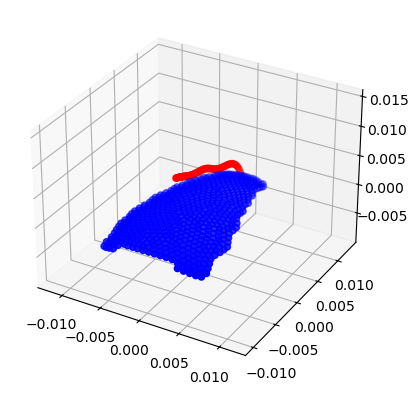

control point connects to 8 vertices


In [32]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

mesh, softbody = data.get_xpbd_grape()

# Hardcoded control trajectory
# control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
#                                [0.000186, 0.008863, 0.002481],
#                                [0.000208, 0.00664, 0.003481],
#                                [0.000197, 0.004594, 0.003481],
#                                [0.000208, 0.002349, 0.003481],
#                                [0.000197, -0.00004, 0.003481],
#                                [0.000208, -0.00204, 0.003481],
#                                [0.000208, -0.00404, 0.008502]])
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000186, 0.008863, 0.002481],
                               [0.000208, 0.00664, 0.003521],
                               [0.000197, 0.004594, 0.004361],
                               [0.000208, 0.002349, 0.005903],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00204, 0.007502],
                               [0.000208, -0.00404, 0.008502]])

# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), 10 * control_trajectory.shape[0])  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:, 0], mesh.points[:, 1], mesh.points[:, 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()


control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.init_grasp_constraints(loc=deepcopy(control_trajectory[0]), radius=1e-3)


cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    # V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)


#################################### Plot ###################################

pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
mesh_actor = pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')
# pl.open_gif('energy.gif')
energy_list = []
tense_list = []
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.grasp_point = control_trajectory[t].clone()

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        # print(torch.sigmoid(1e9 * (1e-8 - energy)))
        # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))
        color = energy.squeeze().cpu().numpy()
        pl.remove_actor(mesh_actor)
        mesh.points = softbody.V.cpu().numpy()[:600]
        mesh_actor = pl.add_mesh(mesh, scalars=color, cmap='jet', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
        # pl.show(interactive_update=True)
        energy_list.append(np.sum(color))
        tense_list.append(np.sum(color > 1e-10))
        # pl.write_frame()
# pl.close()


In [33]:
parallel_peel_energy = energy_list.copy()
parallel_peel_tense = tense_list.copy()

torch.Size([600, 3])
torch.Size([1200, 3])


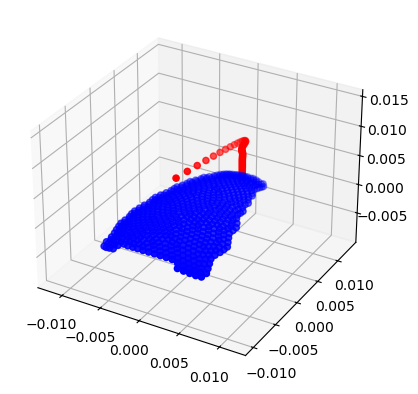

control point connects to 8 vertices


In [34]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

mesh, softbody = data.get_xpbd_grape()

# Hardcoded control trajectory
# control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
#                                [0.000186, 0.008863, 0.002481],
#                                [0.000208, 0.00664, 0.003481],
#                                [0.000197, 0.004594, 0.003481],
#                                [0.000208, 0.002349, 0.003481],
#                                [0.000197, -0.00004, 0.003481],
#                                [0.000208, -0.00204, 0.003481],
#                                [0.000208, -0.00404, 0.008502]])
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000224, 0.010794, 0.000233],
                               [0.000224, 0.010794, 0.001233],
                               [0.000224, 0.010794, 0.002233],
                               [0.000224, 0.010794, 0.003233],
                               [0.000224, 0.010794, 0.004233],
                               [0.000224, 0.010794, 0.005233],
                               [0.000208, -0.00404, 0.008502]])

# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), 10 * control_trajectory.shape[0])  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:, 0], mesh.points[:, 1], mesh.points[:, 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()


control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.init_grasp_constraints(loc=deepcopy(control_trajectory[0]), radius=1e-3)


cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    # V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)


#################################### Plot ###################################

pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
mesh_actor = pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')
# pl.open_gif('energy.gif')
energy_list = []
tense_list = []
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.grasp_point = control_trajectory[t].clone()

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        # print(torch.sigmoid(1e9 * (1e-8 - energy)))
        # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))
        color = energy.squeeze().cpu().numpy()
        pl.remove_actor(mesh_actor)
        mesh.points = softbody.V.cpu().numpy()[:600]
        mesh_actor = pl.add_mesh(mesh, scalars=color, cmap='jet', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
        # pl.show(interactive_update=True)
        energy_list.append(np.sum(color))
        tense_list.append(np.sum(color > 1e-10))
        # pl.write_frame()
# pl.close()


In [35]:
direct_peel_energy = energy_list.copy()
direct_peel_tense = tense_list.copy()

Text(0, 0.5, 'energy')

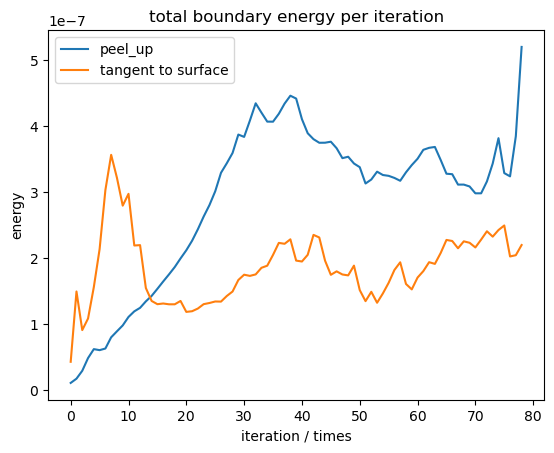

In [36]:
plt.plot(direct_peel_energy, label='peel_up')
plt.plot(parallel_peel_energy, label='tangent to surface')
plt.legend()
plt.title('total boundary energy per iteration')
plt.xlabel('iteration / times')
plt.ylabel('energy')

Text(0, 0.5, 'number')

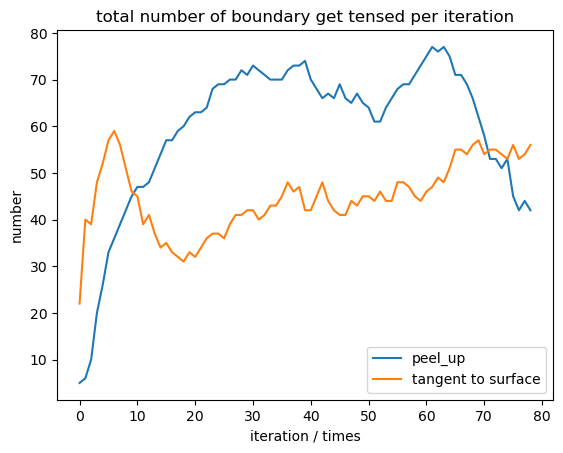

In [38]:
plt.plot(direct_peel_tense, label='peel_up')
plt.plot(parallel_peel_tense, label='tangent to surface')
plt.legend()
plt.title('total number of boundary get tensed per iteration')
plt.xlabel('iteration / times')
plt.ylabel('number')